# Manual Implementation of Word Embeddings Using CBOW

In this (fairly bare-bones) implementation, we manually create word embeddings using the **Continuous Bag of Words (CBOW)** method.  
While libraries like `gensim` or pre-trained models like `Word2Vec` and `BERT` can do this with a single line of code, our goal here is to build a foundational understanding of how word embeddings are created from scratch.  

The idea is to focus on the core mechanics of CBOW while skipping advanced optimizations for now.  
By the end of this notebook, we'll have a clearer picture of how word vectors are generated and how they represent semantic relationships.  

---

## Key Highlights  

1. **Custom Implementation**:  
   - This implementation does not use pre-built deep learning modules. It’s intentionally basic to show what’s happening under the hood.  

2. **Focus on Fundamentals**:  
   - The goal is to grasp the mechanics of CBOW, not to optimize performance or accuracy.  

3. **Simplified Pipeline**:  
   - Hyperparameter tuning, rigorous preprocessing, and advanced evaluation techniques have been skipped intentionally to keep the focus on the essentials.  

---

## Scope for Future Improvement  

1. **Hyperparameter Tuning**:  
   - Experiment with different values for learning rate, hidden layer size, and epochs to improve performance.  
   - Use techniques like grid search or random search for systematic tuning.  

2. **Improved Preprocessing**:  
   - Apply advanced lemmatization techniques for better word normalization.  
   - Use more sophisticated tokenization to handle contractions, punctuation, and multi-word expressions.  

3. **Testing Quality of Embeddings**:  
   - Evaluate embeddings using downstream tasks like **sentiment analysis**, clustering, or word analogies.  
   - Compare results against advanced models like **RoBERTa** or **BERT** for benchmarking.  

4. **Integration with Downstream Tasks**:  
   - Integrate embeddings into applications like recommendation systems or text classification to assess practical utility.  

---

## Closing Remarks  

This implementation skips many important steps, like regularization, rigorous preprocessing, and hyperparameter tuning.  
The aim is not to build a production-ready model but to provide a clear understanding of how word embedding vectors are generated.  

With these fundamentals in place, we can confidently explore more advanced NLP techniques and frameworks in the future.  


In [281]:
# Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
import nltk
import re
import torch

pd.set_option("display.max_columns", 500)

In [282]:
# Download necessary nltk tools

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [283]:
# Read corpus to train the model on. For this exercise we select some random news articles. The data is available on Kaggle. 

with open("reddit_news_headlines.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

# game_of_thrones1_graft.txt

### Text preprocessing

In [284]:
# We follow the following steps to preprocess data. Ideally, we would also include more rigorous cleaning methods
# like removing emojis and words from other languages etc. But since we are working with a simple corpus, these steps are not necessary.

# Preprocess 1

"""
1. Lower case
2. Remove punctuation, special characters, numbers
2. Remove stopwords/punctuation
3. Tokenize and Stemming
"""

stop_words = set(stopwords.words('english'))
raw_text = raw_text.lower()
raw_text = re.sub(r"[^a-zA-Z\s.]", "", raw_text)
raw_text = re.sub(r"'s\b", "", raw_text)  # Remove occurrences of "'s"
# raw_text = re.sub(r"([\\\[\]\{\},__;!?/*^@'\(\)\:\'\"\`$&\%’“”-_])|(\n)|(\d+)", "", raw_text)
raw_text = re.sub(r"-", " ", raw_text)

raw_text = re.sub(r"\s+\.", ".", raw_text)

# filter_text = " ".join(raw_text)

In [285]:
# LEMMATIZE WORDS

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to lemmatize the word
def lemmatize_word(x):
    pos_tags = nltk.pos_tag([x])
    lemmatized_word = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
    stemmed = [stemmer.stem(word) for word in lemmatized_word]
    return lemmatized_word[0]



In [286]:
# Preprocess 2
"""
Lemmatizing words handles cases like 'drawing' and 'drawn' reduced to 'draw'
"""
words = word_tokenize(raw_text)
words_lemmatized = [lemmatize_word(word) for word in words]
filter_text = " ".join(words_lemmatized)

In [287]:
# Preprocess 3
"""
Remove stop_words.
Remove whitespace between period and preceding word.
Replace multiple periods with a single period.
Introduce space between period and following word if there is none.
"""
filter_text = word_tokenize(filter_text)
filter_text = " ".join([word for word in filter_text if word not in stop_words])

filter_text = filter_text.replace(" .",".")
filter_text = re.sub(r'\.{2,}', '.', filter_text)
filter_text = re.sub(r'\.(?=\S)', '. ', filter_text)


### Vocabulary Creation and One-Hot Encoding

In this step, we create a **vocabulary** from our text corpus. A vocabulary consists of unique words, which form the foundation for many **Natural Language Processing (NLP)** tasks. 

Next, we generate a **repository** to store the **one-hot encoded** representations of each word in the vocabulary. This allows us to represent each word as a vector, where each word in the vocabulary is associated with a unique index and is represented by a vector of zeros, except for the position corresponding to the word, which is set to one.



In [288]:
print(f"Corpus words: {len([word.strip() for word in re.split(r'[ .]+', filter_text)])}")

Corpus words: 14131


In [289]:
vocab = set(word.strip() for word in re.split(r'[ .]+', filter_text) if word.strip())
vocab = {word for word in vocab if word not in stop_words}

In [290]:
words_encoding = pd.DataFrame(vocab)
words_encoding.columns = ["vocab"]
words_encoding["vocab"] = words_encoding["vocab"].str.replace(".","")

In [291]:
words_encoding = pd.get_dummies(words_encoding).astype(int)
words_encoding.columns = [col.split('_')[1] for col in words_encoding.columns] 

In [292]:
reorder_columns = words_encoding.idxmax(axis=1).values
words_encoding = words_encoding[reorder_columns]
words_encoding.head()


,fa,syndrome,ambivalence,ira,line,campus,brit,flag,power,board,mexico,outbreak,class,nyt,vojislav,might,microlending,palm,massage,bestknown,vatican,nobody,gaddafi,nephew,piggy,sassenach,opening,conquest,uganda,lane,virulent,office,hears,remains,indict,frontline,brief,dallas,fuckface,lok,excommunists,commute,exsas,stock,download,jazeera,centre,age,history,eiffel,colonise,waver,canal,image,crass,hood,uae,confess,lapse,feb,crazy,mohammed,hoodwink,execute,sadrists,golfer,antithesis,meltdown,mohican,creepy,crane,faulty,atrocity,fox,ha,quiet,whitehall,war,prowar,colombia,google,englandestan,backward,sunglass,nabawi,add,act,test,lima,mohamed,spitfire,bus,survival,searcher,bbc,offensve,considers,background,barrel,cycling,lose,staff,fatigue,prominent,monsanto,toss,wilt,combine,liability,critic,mountain,ring,constant,precinct,tiger,somewhat,evade,pain,torpedo,uncovered,cleaver,unrest,mexican,wood,waterboarding,emporium,whether,sunday,gratuity,japan,preziosi,primeminister,protestors,bite,afghanistanas,project,piranha,fume,region,athens,unveil,abstinence,lawn,none,reuters,clear,eyewitness,fidel,ben,art,husband,president,guard,denmark,xray,deadlock,oust,rap,comment,hero,quebec,traveler,zero,spain,strip,interviewer,warp,brazil,many,scanner,screen,claim,ceo,preparation,overlook,da,voice,protest,rwandan,fail,mailin,chuck,crosswind,every,country,climbed,individual,killing,parlor,electricity,makeover,tour,militarily,rare,dachshund,councillor,portion,ongoing,exxon,market,twilight,paitent,cnn,jfk,david,washington,cooperation,misstep,flee,chosen,cd,advise,theater,tornado,dangerous,exmi,outstayed,u,faughey,skilled,pathetic,occupancy,heavily,action,chopper,russell,englishman,najnowsze,rd,jobless,director,fiddle,bolivia,v,barack,justice,central,york,influence,austrian,oneday,rinf,zealand,mistake,semitically,trillion,roman,mobster,noogie,institute,...,map,emerge,croatia,deepmemo,serbia,farmer,jr,capitalist,september,wale,britain,fuel,homeschool,symbol,tablet,baitullah,implement,fortresslike,eugenics,thwart,yerevan,blast,wipe,tony,excellence,brace,passport,osce,topic,mercenary,bahrain,plant,list,babacan,antiislamic,happen,mulch,chemicalorigin,graham,mobes,moudud,alqaida,intervention,north,mugabe,available,pandemic,save,vid,beating,grateful,behind,disastrous,scotland,museum,prostitute,know,apologizes,thrash,injured,greedy,accuse,worshipper,hostile,debtridden,harbor,spectacular,due,dgfi,associate,molehunt,construction,syria,pastor,dummy,criminalizes,revisit,mostly,outside,petty,subversive,equality,disgrace,wheat,lagardere,captor,blowback,juarez,corinne,cyber,circumstance,ballistic,candidate,dodi,tension,secretive,life,fishcakes,gridlock,inside,reduces,honor,yesterday,castropedia,green,ajudge,goodness,translate,szamuely,dolly,viktor,parliament,desire,hitman,ticket,sell,anticipate,easy,blonde,somalia,bonanza,worthless,kong,cabinet,inflation,edward,cannibalism,celebrate,vs,manipulate,fin,indie,blingbling,role,mosque,expolice,sectarian,critique,scien,hrw,islam,fattest,confirms,destabilize,speak,euun,protect,object,delivery,stmicro,reporting,conservatism,biblical,battalion,impend,culloden,elminate,rotten,emergency,spending,fiji,eve,hamburg,eruption,get,gag,east,buy,cartel,tiny,active,praise,serious,tehran,ease,asset,shin,gabonese,struggle,antiquity,jesus,niane,entangle,sequel,lock,male,affect,heart,simmer,boil,renal,qaeda,bowman,poor,house,halifax,microbicide,psychopathic,channel,meeting,banja,campaign,expensive,demonocracy,germany,surge,israelite,tarnished,respond,humananimal,weve,supergun,lama,albas,across,release,queenfish,randomly,unleashes,rip,bailey,billy,hussein,complaint,dealer,hatred,gabb,inhumane,russia,stability,larry,yahoo,unveiled,passenger,city,advice,gift,sanitation,tale,national,restore,mph,sa,cardinal,tourism,church,ricin,blackstone,cook,germanled
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Convert Text to Input Ready for Neural Network

In the following steps, we will transform the raw text into a format that is suitable for input into a neural network, specifically for training the **Continuous Bag of Words (CBOW)** algorithm.

#### **CBOW Overview**

The **CBOW** model works by predicting a **focus word** using a window of surrounding **context words**. The size of this window is a hyperparameter that can be adjusted. For this exercise, we will consider seven context words on each side of the focus word, resulting in a total of eight context words.

#### **Objective**

The objective of this process is to generate two primary columns:

1. **Target Word**: This column will contain the one-hot encoded version of the focus word, referred to as the "target."
   
2. **Context Words**: This column will contain the one-hot encoded representations of the surrounding context words. The number of context words is determined by the hyperparameter `num_neighbours`. For each focus word, we will include `2*m` context words, where `m` is the number of neighbours.

By organizing the data this way, we create a structure that allows us to train the CBOW model effectively, using the target word and its context words to learn meaningful word embeddings.


In [293]:
# Define function to get context words

def make_windows(sentence, num_neighbours):
    family = []
    sentence = sentence.split()
    sentence = [word for word in sentence if word not in stop_words and len(word) > 2]
    
    for idx, word in enumerate(sentence):  
        if idx == 0:
            x = {}
            try:
                x[word] = [sentence[idx + 1]]
                family.append(x)
                continue
            except:
                continue
            
        context_words = []
        # Left neighbours
        for step in range(1, num_neighbours + 1):
            try:
                context_words.append(sentence[idx - step])  
            except IndexError:  # Ignore if we go out of bounds
                pass
        
        # Right neighbours
        for step in range(1, num_neighbours + 1):
            try:
                context_words.append(sentence[idx + step]) 
            except IndexError:  # Ignore if we go out of bounds
                pass
        
        # Append the context and target word
        x = {}
        x[word] = context_words
        family.append(x)
    
    return family


In [294]:
# For each sentence in the text we will have a list of dictionaries. The dictionary looks as shown below:
"""
{
    focus_word1: ['context_word11', 'context_word12'.......'],
    focus_word2: ['context_word21', 'context_word22'.......'],
 }
"""

data = []
num_neighbours = 7
for sent in sent_tokenize(filter_text):
    data.append(make_windows(sent, num_neighbours=num_neighbours))    

In [295]:
data = [item for sublist in data for item in sublist]

In [296]:
data_df = pd.DataFrame()
data_df["context_words"] = [list(item.values())[0] for item in data]
data_df["target"] = [list(dictionary.keys())[0] for dictionary in data]

In [297]:
data_df["context_words"] = data_df["context_words"].apply(
    lambda row: [re.sub(r",|\.|\(\)|;", "", word) for word in row]
)

data_df["target"] = data_df["target"].str.replace(r",|\.|\(\)|;", "", regex=True)

In [298]:
data_df["target"] = data_df["target"].apply(lemmatize_word)
data_df["context_words"] = data_df["context_words"].apply(lambda row: [lemmatize_word(word) for word in row])

In [299]:
data_df["num_context_words"] = data_df["context_words"].apply(len)

In [300]:
data_df = data_df.query("num_context_words == @num_neighbours * 2")

In [301]:
# Function to convert all the words in above dataframe into their one-hot-encoded versions. 
# This is where we invoke the dictionary created previously called "words_encoding."

"""
First, we check that data_df contains only valid words, i.e., no word is out of vocabulary
"""
valid_words = set(words_encoding.columns)

def is_valid_row(row):
    return all(word in valid_words for word in row['context_words']) and row['target'] in valid_words

data_df = data_df[data_df.apply(is_valid_row, axis=1)].reset_index(drop=True)

"""
Second, return one-hot-encoded vectors for each word
"""

def word2ohe(word):
    ohe_vector = words_encoding[word].values
    return ohe_vector

In [302]:
data_df["context_words_ohe"] = data_df["context_words"].apply(lambda word_list: [word2ohe(word) for word in word_list])

In [303]:
data_df["target_ohe"] = data_df["target"].apply(word2ohe)

In [304]:
data_df.sample(frac=1).head()

,context_words,target,num_context_words,context_words_ohe,target_ohe
7947,"[violence, military, asiapacific, base, gender...",woman,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9347,"[anniversary, fifth, iraq, remember, reason, m...",start,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7724,"[iraqi, million, cross, red, bombing, pakistan...",lack,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10582,"[human, china, spotlight, current, disgrace, o...",right,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3029,"[jr, buckley, william, telegraph, china, count...",die,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Build Neural Network

The neural network for training the **CBOW** model will consist of one hidden layer. Each input to the network will have the shape **2*m, vocab_len**, where:
- `m` is the number of neighbours on each side of the focus word (context words).
- `vocab_len` is the length of the one-hot encoded vectors, representing the size of the vocabulary.

For this exercise, we choose a word embedding length of 40. This means that the hidden layer will also have 40 neurons to match the dimensionality of the word embeddings. The output from the hidden layer is passed through a **softmax layer**, which is used to normalize the output into probabilities.

The model will be trained using **cross-entropy loss** as the loss metric, which is commonly used in classification tasks to measure the difference between predicted and true distributions.

#### Important Considerations:
- After each epoch, it is essential to set the gradients to zero using `optimizer.zero_grad()`. This step ensures that gradients do not accumulate across epochs, which would otherwise cause incorrect backpropagation and lead to issues in model training.


In [305]:
class MyCBOW():
    
    def __init__(self, X):
        embedding_len = 40
        vocab_len = X.shape[2] 
        self.weights = torch.rand(vocab_len, embedding_len, dtype=torch.float32, requires_grad=True)
        self.bias = torch.zeros(embedding_len, dtype=torch.float32, requires_grad=True)
        self.output_weights = torch.rand(embedding_len, vocab_len, dtype=torch.float32, requires_grad=True)
   
    def forward(self, X):
        output = torch.matmul(X, self.weights).mean(dim=1) + self.bias
        output_logits = torch.matmul(output, self.output_weights)
        return torch.softmax(output_logits, dim = 1)  # shape (samples,embedding_len)
    
    def compute_loss(self, y_pred, y):
        loss = -(y*torch.log(y_pred)).sum(dim=1).mean()
        return loss
                 

In [306]:
X_np = np.array([x for x in data_df["context_words_ohe"].values])
X = torch.tensor(X_np, dtype=torch.float32)

y_np = np.array([x for x in data_df["target_ohe"].values])
y = torch.tensor(y_np, dtype=torch.float32)


In [307]:
# Check if shape of input X is correct

print(f"samples: {len(data_df)}")
print(f"context words: {2*num_neighbours}")
print(f"vocabulary: {len(vocab)}")

print(f"\nInput shape: {X.shape}")
print("\nShape of input should be (samples, context_words, vocabulary)")


samples: 11299
context words: 14
vocabulary: 4505

Input shape: torch.Size([11299, 14, 4505])

Shape of input should be (samples, context_words, vocabulary)


### Training the model

In [308]:
model = MyCBOW(X)

epochs = 1000
learning_rate = 0.8
track_loss = []
for epoch in range(epochs):
    y_pred = model.forward(X)
    loss = model.compute_loss(y_pred ,y)
    
    loss.backward()

    with torch.no_grad():
        model.weights -= learning_rate * model.weights.grad
        model.bias -= learning_rate * model.bias.grad
        model.output_weights -= learning_rate * model.output_weights.grad
    
    model.weights.grad.zero_()
    model.bias.grad.zero_()
    model.output_weights.grad.zero_()

    track_loss.append(loss.detach())
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 8.847309112548828
Epoch: 100. Loss: 8.349026679992676
Epoch: 200. Loss: 8.198898315429688
Epoch: 300. Loss: 8.041525840759277
Epoch: 400. Loss: 7.925321102142334
Epoch: 500. Loss: 7.846891403198242
Epoch: 600. Loss: 7.793822288513184
Epoch: 700. Loss: 7.75588321685791
Epoch: 800. Loss: 7.727385997772217
Epoch: 900. Loss: 7.705085754394531


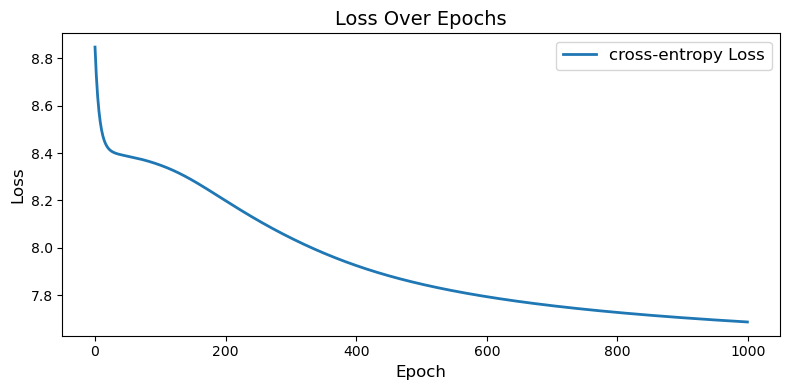

In [309]:
# Plotting the loss
plt.figure(figsize=(8, 4))
plt.plot(range(len(track_loss)), track_loss, label="cross-entropy Loss", color='#1f77b4', linewidth=2)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Loss Over Epochs", fontsize=14)
plt.tight_layout()

plt.show()

In [310]:
# Save the model's parameters (weights and bias)
torch.save({
    'weights': model.weights,
    'bias': model.bias,
    'output_weights': model.output_weights
}, "manual_word2vec.pth")


In [311]:
"""
Map the words in our vocabulary with their respective weights.
The most crucial part is to ensure that each word is zipped with its respective weights. That is the reason why the 
columns of the words_encoding dataframe were rearranged previously. 

[NOTE: alternatively, word embeddings for each word can be obtained by mutliplying the weight-matrix (shape = embedding_len X vocab_len) with the 
input-matrix of one-hot-encoded vectors (shape = vocab_len x vocab_len). The resultant matrix of this operation will be a matrix of size 
(embedding_len X vocab_len) such that the columns are the word embeddings of our vocabulary. Like before, care must be taken to keep track of the
word-index pairing in the input matrix.]

"""

final_embeddings = {word:embeddings for word,embeddings in zip(words_encoding[reorder_columns].columns, model.weights.detach().numpy())}


### Evaluation 
##### [Work In Progress]

There are several ways to evaluate the quality of the embeddings generated by our simple model. Some of these methods include:

- **Examining Similarity**: Analyzing the top `x` most similar words for each of the `y` most frequent words in the corpus.
- **Benchmarking Against Advanced Models**: Comparing the embeddings with those generated by state-of-the-art, off-the-shelf pre-trained models like RoBERTa, BERT, etc.
- **Sentiment Analysis Accuracy**: Evaluating how well the embeddings perform in sentiment analysis tasks.

For now, we just compare word similarities between random word-pairs.


In [344]:
word1 = words_encoding.columns[983]
word2 = words_encoding.columns[73]

word1 = "google"
word2 = "facebook"

def cosine_similarity(word1, word2):
    embedding1 = final_embeddings[word1]
    embedding2 = final_embeddings[word2]

    embedding1 = embedding1/np.linalg.norm(embedding1)
    embedding2 = embedding2/np.linalg.norm(embedding2)
    
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

print(f"{word1} and {word2}")
cosine_similarity(word1, word2)

google and facebook


0.7771353